In [46]:
'''
created on June 6th 2022 @ 3rd Eddy Cross Disciplinary Symposium, Vail, CO, USA
Code based on original idea by Dan Marsh (NCAR, University of Leeds)
Authors:
Gregory Cooke (University of Leeds, pygjc@leeds.ac.uk)
Allison Youngblood (NASA Goddard)
'''

'''
USER GUIDE
Code to read in files from the MUSCLES database
and scale them to be used in various atmospheric models
for different planets in those stellar systems

Run each cell until drop down menus appear
Select your desired options from dropdown menus
'''

'''
To do list
wget NASA exoplanet archive
rebin spectra
save out spectra file
add different climate model wavelength grids (only WACCM so far)
comment code better
'''

#imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ipywidgets import interactive
import matplotlib.gridspec as gridspec
from astropy.io import fits

In [47]:
# return subscript number or text as a string
def sub(Input):
    return r'$_{'+str(Input)+'}$'

# return superscript number or text as a string
def sup(Input):
    return r'$^{'+str(Input)+'}$'

In [50]:
'''
program options begin here
List of MUSCLES database below
'''

Stellar_names = {'GJ 1132':'https://archive.stsci.edu/missions/hlsp/muscles/gj1132/hlsp_muscles_multi_multi_gj1132_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 15A':'https://archive.stsci.edu/missions/hlsp/muscles/gj15a/hlsp_muscles_multi_multi_gj15a_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 1214':'https://archive.stsci.edu/missions/hlsp/muscles/gj1214/hlsp_muscles_multi_multi_gj1214_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 163':'https://archive.stsci.edu/missions/hlsp/muscles/gj163/hlsp_muscles_multi_multi_gj163_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 176':'https://archive.stsci.edu/missions/hlsp/muscles/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 436':'https://archive.stsci.edu/missions/hlsp/muscles/gj436/hlsp_muscles_multi_multi_gj436_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 581':'https://archive.stsci.edu/missions/hlsp/muscles/gj581/hlsp_muscles_multi_multi_gj581_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 649':'https://archive.stsci.edu/missions/hlsp/muscles/gj649/hlsp_muscles_multi_multi_gj649_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 667 C':'https://archive.stsci.edu/missions/hlsp/muscles/gj667c/hlsp_muscles_multi_multi_gj667c_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 674':'https://archive.stsci.edu/missions/hlsp/muscles/gj674/hlsp_muscles_multi_multi_gj674_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 676 A':'https://archive.stsci.edu/missions/hlsp/muscles/gj676a/hlsp_muscles_multi_multi_gj676a_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 699':'https://archive.stsci.edu/missions/hlsp/muscles/gj699/hlsp_muscles_multi_multi_gj699_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 729':'https://archive.stsci.edu/missions/hlsp/muscles/gj729/hlsp_muscles_multi_multi_gj729_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 832':'https://archive.stsci.edu/missions/hlsp/muscles/gj832/hlsp_muscles_multi_multi_gj832_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 849':'https://archive.stsci.edu/missions/hlsp/muscles/gj849/hlsp_muscles_multi_multi_gj849_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 876':'https://archive.stsci.edu/missions/hlsp/muscles/gj876/hlsp_muscles_multi_multi_gj876_broadband_v22_adapt-const-res-sed.fits',
                 'HD40307':'https://archive.stsci.edu/missions/hlsp/muscles/hd40307/hlsp_muscles_multi_multi_hd40307_broadband_v22_adapt-const-res-sed.fits',
                 'HD85512':'https://archive.stsci.edu/missions/hlsp/muscles/hd85512/hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits',
                 'HD97658':'https://archive.stsci.edu/missions/hlsp/muscles/hd97658/hlsp_muscles_multi_multi_hd97658_broadband_v22_adapt-const-res-sed.fits',
                 'L-980-5':'https://archive.stsci.edu/missions/hlsp/muscles/l-980-5/hlsp_muscles_multi_multi_l-980-5_broadband_v23_adapt-const-res-sed.fits',
                 'LHS-2686':'https://archive.stsci.edu/missions/hlsp/muscles/lhs-2686/hlsp_muscles_multi_multi_lhs-2686_broadband_v23_adapt-const-res-sed.fits',
                 'TRAPPIST-1':'https://archive.stsci.edu/missions/hlsp/muscles/trappist-1/hlsp_muscles_multi_multi_trappist-1_broadband_v23_adapt-const-res-sed.fits',
                 'V-EPS-ERI':'https://archive.stsci.edu/missions/hlsp/muscles/v-eps-eri/hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits',
                 'GJ551':'https://archive.stsci.edu/missions/hlsp/muscles/gj551/hlsp_muscles_multi_multi_gj551_broadband_v22_adapt-const-res-sed.fits'}

#get a drop down menu
import ipywidgets as widgets
#select directories for MUSCLES files
MUSCLES_files = widgets.Dropdown(options=(Stellar_names),description='MUSCLES Files:',disabled=False)
display(MUSCLES_files)

Dropdown(description='MUSCLES Files:', options={'GJ 1132': 'https://archive.stsci.edu/missions/hlsp/muscles/gj…

In [135]:
'''
set Spectra_name_same_as_host_name = False if looking at exoplanets around
a different star to the ones in the MUSCLES database
i.e you want spectra for an M8 star but the closest spectra availiable is TRAPPIST-1
otherwise in this example you will only be able to select TRAPPIST-1 planets 
if Spectra_name_same_as_host_name = True
'''
Spectra_name_same_as_host_name = True

In [136]:
#get star name
star_name = [k for k, v in Stellar_names.items() if v == MUSCLES_files.value][0]


In [268]:
# Import MUSCLES spectra
import os
if(os.path.isfile(MUSCLES_files.value)): print('File already downloaded')
else:os.system('wget '+ MUSCLES_files.value)

--2022-06-07 22:57:54--  https://archive.stsci.edu/missions/hlsp/muscles/trappist-1/hlsp_muscles_multi_multi_trappist-1_broadband_v23_adapt-const-res-sed.fits
Resolving archive.stsci.edu (archive.stsci.edu)... 130.167.201.60
Connecting to archive.stsci.edu (archive.stsci.edu)|130.167.201.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13538880 (13M) [allicashion/octet-stream]
Saving to: ‘hlsp_muscles_multi_multi_trappist-1_broadband_v23_adapt-const-res-sed.fits.2’

     0K .......... .......... .......... .......... ..........  0%  614K 21s
    50K .......... .......... .......... .......... ..........  0% 1.16M 16s
   100K .......... .......... .......... .......... ..........  1% 59.4M 11s
   150K .......... .......... .......... .......... ..........  1% 1.18M 11s
   200K .......... .......... .......... .......... ..........  1% 70.1M 9s
   250K .......... .......... .......... .......... ..........  2% 74.8M 7s
   300K .......... .......... .......... 

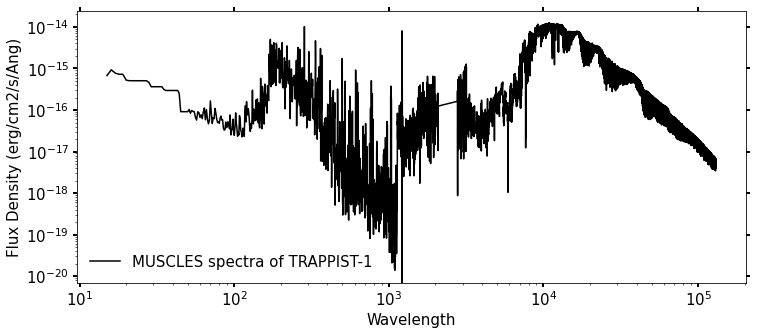

In [269]:
spec = fits.getdata(MUSCLES_files.value,1)
plt.figure(figsize = (12,5))
plt.plot(spec['WAVELENGTH'],spec['FLUX'], color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density (erg/cm2/s/Ang)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [270]:
#convert to mW/m2/nm
per_cm2_to_per_m2 = 100**2
erg_per_s_to_mW = 1e-4
per_Ang_to_per_nm = 10
New_flux = spec['FLUX'] * erg_per_s_to_mW * per_cm2_to_per_m2 * per_Ang_to_per_nm
Wavelength_nm = spec['WAVELENGTH']/10

In [271]:
# plot in new units
'''
plt.figure(figsize = (12,5))
plt.plot(Wavelength_nm,New_flux, color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)
'''

"\nplt.figure(figsize = (12,5))\nplt.plot(Wavelength_nm,New_flux, color = 'k', label = 'MUSCLES spectra of '+star_name)\nplt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)\nplt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')\nplt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')\nplt.legend(loc = 0, frameon = False, fontsize = 15)\n"

In [272]:
#remove MUSCLES files in current directory
os.system('rm *muscles*.fits')

0

In [273]:
#find total stellar irradiance from file
from scipy.integrate import trapz
#get total stellar irradiance at top of atmosphere
TSI_spectra = trapz(New_flux,Wavelength_nm)
print('Total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

Total stellar irradiance relative to the Sun: 8.605194006526416e-17


In [274]:
# scale TSI
Scaled_flux_to_Earth = New_flux/(TSI_spectra/1360000)
TSI_spectra = trapz(Scaled_flux_to_Earth, Wavelength_nm)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

Scaled total stellar irradiance relative to the Sun: 1.0


In [275]:
#Select climate model
Climate_model_list = ['WACCM','CAM','ExoCam','UM','ROCKE-3D','CCSM3','Atmos','ExoPrime']
Climate_model_selection = widgets.Dropdown(options=Climate_model_list,description='Select climate model',disabled=False)
display(Climate_model_selection)

Dropdown(description='Select climate model', options=('WACCM', 'CAM', 'ExoCam', 'UM', 'ROCKE-3D', 'CCSM3', 'At…

File already downloaded


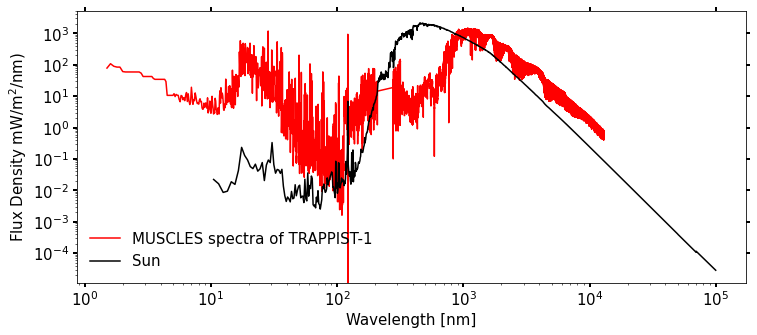

In [276]:
#Compare to WACCM standard solar file
if (Climate_model_selection.value == 'WACCM' or Climate_model_selection.value == 'CAM'):
    #check for file. Download if not in directory
    if(os.path.isfile('SolarForcingCMIP6piControl_c160921.nc')): print('File already downloaded')
    else: os.system('wget https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/atm/cam/solar/SolarForcingCMIP6piControl_c160921.nc --no-check-certificate')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file

    ds = xr.open_dataset(solar_file)#attach file to dataset
    ssi = ds['ssi'].isel(time=0) #define dataset from file
    WACCM_Flux = ssi.values #flux values
    WACCM_wavelength = ssi.wavelength.values #wavelength grid

    #compare spectra to Sun
    plt.figure(figsize = (12,5))
    plt.plot(Wavelength_nm, Scaled_flux_to_Earth, color = 'r', label = 'MUSCLES spectra of '+star_name)
    plt.plot(WACCM_wavelength,WACCM_Flux, color = 'k', label = 'Sun')
    plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
    plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
    plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
    plt.legend(loc = 0, frameon = False, fontsize = 15)
    
elif(Climate_model_selection.value == 'ExoCAM'):
    print('ExoCam spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'UM'):
    print('UM spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'ROCKE-3D'):
    #check for file. Download if not in directory
    if(os.path.isfile('sun')): print('File already downloaded')
    else: os.system('wget https://portal.nccs.nasa.gov/GISS_modelE/ROCKE-3D/stellar_spectra/sun')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file
    ROCKE_3D_solar_input = np.genfromtxt('sun', skip_header = 5, skip_footer = 1)
    ROCKE_3D_Wavelength = ROCKE_3D_solar_input[:,0]
    ROCKE_3D_Wavelength_nm = ROCKE_3D_Wavelength*1e9
    ROCKE_3D_Flux = ROCKE_3D_solar_input[:,1]
    
    #compare spectra to Sun
    plt.figure(figsize = (12,5))
    plt.plot(Wavelength_nm, Scaled_flux_to_Earth, color = 'r', label = 'MUSCLES spectra of '+star_name)
    plt.plot(ROCKE_3D_Wavelength_nm, ROCKE_3D_Flux, color = 'k', label = 'Sun')
    plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
    plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
    plt.ylabel('Irradiance [W/m]'+sup(-3), fontsize = 15); plt.yscale('log')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc = 0, frameon = False, fontsize = 15)
    
elif(Climate_model_selection.value == 'CCSM3'):
    print('CCSM3 spectrum input file unknown') 
    
elif(Climate_model_selection.value == 'Atmos'):
    if(os.path.isfile('muscles_gj667c.txt')): print('File already downloaded')
    else: os.system('wget https://raw.githubusercontent.com/VirtualPlanetaryLaboratory/atmos/master/PHOTOCHEM/DATA/FLUX/muscles_gj667c.txt')
    ATMOS_gj667c_input = np.genfromtxt('muscles_gj667c.txt')
    ATMOS_gj667c_Wavelength_nm = ATMOS_gj667c_input[:,0]/10
    ATMOS_gj667c_Flux = ATMOS_gj667c_input[:,1]
    
    #compare spectra to GJ 667 C
    plt.figure(figsize = (12,5))
    plt.plot(ATMOS_gj667c_Wavelength_nm, ATMOS_gj667c_Flux, label = 'GJ 667 C')
    plt.plot(Wavelength_nm, Scaled_flux_to_Earth, color = 'r', label = 'MUSCLES spectra of '+star_name)
    plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
    plt.ylabel('Irradiance [??]'+sup(-3), fontsize = 15); plt.yscale('log')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc = 0, frameon = False, fontsize = 15)
    plt.yscale('log')
else:
    print('Spectrum input file unknown')

In [146]:
#Now scale to specific planet in that system
#Use NASA exoplanet archive????

In [304]:
'''
Ideally would wget file from exoplanet archive
! wget https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload | wget https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

For now I have uploaded the file I downloaded and have a temporary fix
'''

if(os.path.isfile('PS_2022.06.06_22.28.545.csv')): print('File already downloaded')
else: os.system('wget -O PS_2022.06.06_22.28.545.csv https://drive.google.com/uc?id=1im9dAmDbHEi-Xbpv8hTGbujJTk9WXkmV&export=download')

File already downloaded


In [306]:
import pandas as pd
NASA_Exo_Archive = pd.read_csv('PS_2022.06.06_22.28.545.csv', skiprows = 290)

/tmp/ipykernel_78/1536157143.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  NASA_Exo_Archive = pd.read_csv('PS_2022.06.06_22.28.545.csv', skiprows = 290)


In [307]:
#Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates() ),description='Find host',disabled=False)
#display(Find_host)

In [309]:
#Find planets based on host name
if (Spectra_name_same_as_host_name == True):
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == star_name]['pl_name']
    Find_planets = widgets.Dropdown(options=planets.drop_duplicates(),description='Find planets',disabled=False)
    display(Find_planets)
else:
    Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates()),description='Find host',disabled=False)
    display(Find_host)
    
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == Find_host.value]['pl_name']
    Find_planets = widgets.Dropdown(options=planets,description='Find planets',disabled=False)
    display(Find_planets)

Dropdown(description='Find planets', options=('TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 d', 'TRAPPIST-1 e', …

In [310]:
#drop nan rows ofr luminosity and orbital period
pl = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value].dropna(subset='st_lum')
pl = pl.dropna(subset='pl_orbsmax')

In [311]:
#find semi-major axis in AU
pl = pl.sort_values(by=['rowupdate'])
semi_major_axis = pl['pl_orbsmax'].iloc[-1]
print('semi-major axis of '+Find_planets.value+' = '+str(semi_major_axis)+' AU')

semi-major axis of TRAPPIST-1 b = 0.01154 AU


In [312]:
#find solar luminosity relative to Sun
stellar_luminosity = 10**pl['st_lum'].iloc[-1]
print('Star has '+str(stellar_luminosity)+ ' times luminosity of Sun')

Star has 0.0005533501092157366 times luminosity of Sun


In [313]:
flux_recieved_relative_to_Earth = stellar_luminosity/(semi_major_axis**2)
print(Find_planets.value+' recieves '+str(flux_recieved_relative_to_Earth)+ ' times flux recieved by Earth')

TRAPPIST-1 b recieves 4.155166035519109 times flux recieved by Earth


In [314]:
#add in infrared wavelengths if required


In [315]:
#rebin to wavelength grid


In [316]:
# rescale to planet
Final_scaled_flux = Scaled_flux_to_Earth * flux_recieved_relative_to_Earth
TSI_spectra = trapz(Final_scaled_flux, Wavelength_nm)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))


Scaled total stellar irradiance relative to the Sun: 4.155166035519111


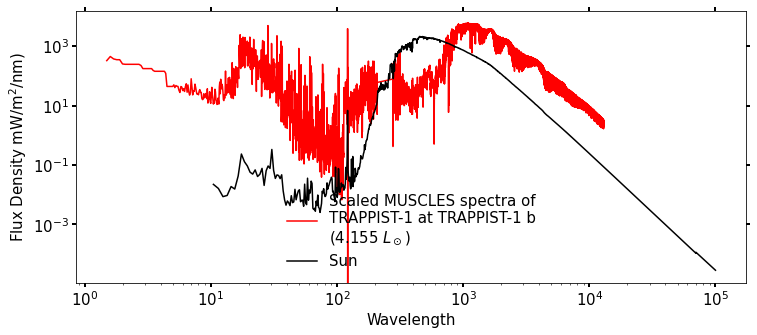

In [317]:
#final spectra compared to Sun
plt.figure(figsize = (12,5))
plt.plot(Wavelength_nm, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(TSI_spectra/1360000,3))+' '+r'$L_\odot$'+')')
plt.plot(WACCM_wavelength,WACCM_Flux, color = 'k', label = 'Sun')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [318]:
#extra information about planet
#orbital period
period = pl['pl_orbper'].iloc[-1]
print(period)

1.510826


In [319]:
#orbital radius
radius = pl['pl_rade'].iloc[-1]
print(radius)

1.116
